<a href="https://colab.research.google.com/github/berberberk/apms-fs-2024/blob/main/APMS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# 1. Генерация нормального распределения

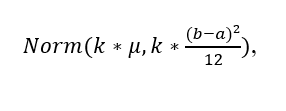

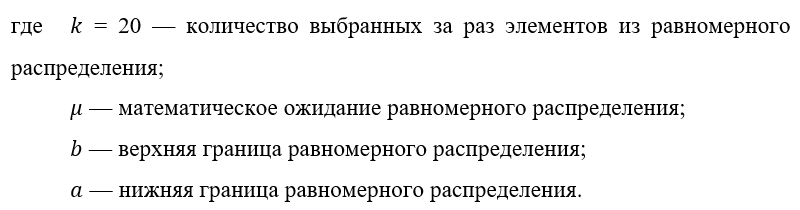

In [2]:
def sample_normal(n=1, mu=0, sigma=1, k=30):
    uniform_sum = np.random.uniform(low=0.0, high=1.0, size=(n, k)).sum(axis=1)
    normalized = (uniform_sum - k / 2) / np.sqrt(k / 12)
    return mu + sigma * normalized

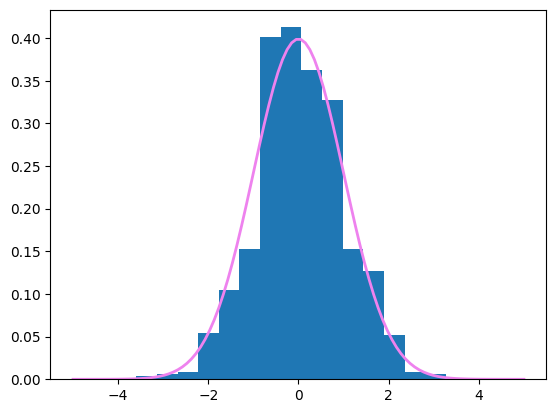

In [3]:
data = sample_normal(n=1000)

x = np.linspace(-5, 5, 100)
p = stats.norm.pdf(x, 0, 1)
plt.hist(data, density=True, bins=15)
plt.plot(x, p, c='violet', lw=2)

## 1.1 Тест на нормальность критерием Пирсона

In [4]:
ks = [3, 30, 300, 3000, 30000, 300000]

for k in ks:
    print(f'k = {k}')

    data = sample_normal(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.norm.cdf(bin_edges, loc=0, scale=1)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=2)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 3
Статистика χ²: 8.025814876584757
p-value: 0.33032307905034264

k = 30
Статистика χ²: 2.8489006313224805
p-value: 0.8986194068578216

k = 300
Статистика χ²: 7.582377628092178
p-value: 0.3708541630097064

k = 3000
Статистика χ²: 9.905490148989069
p-value: 0.19399282599991563

k = 30000
Статистика χ²: 10.7767702113698
p-value: 0.14865694158654372

k = 300000
Статистика χ²: 15.885864550935914
p-value: 0.02617982170473307



## 1.2 Тест на нормальность с помощью анаморфоз

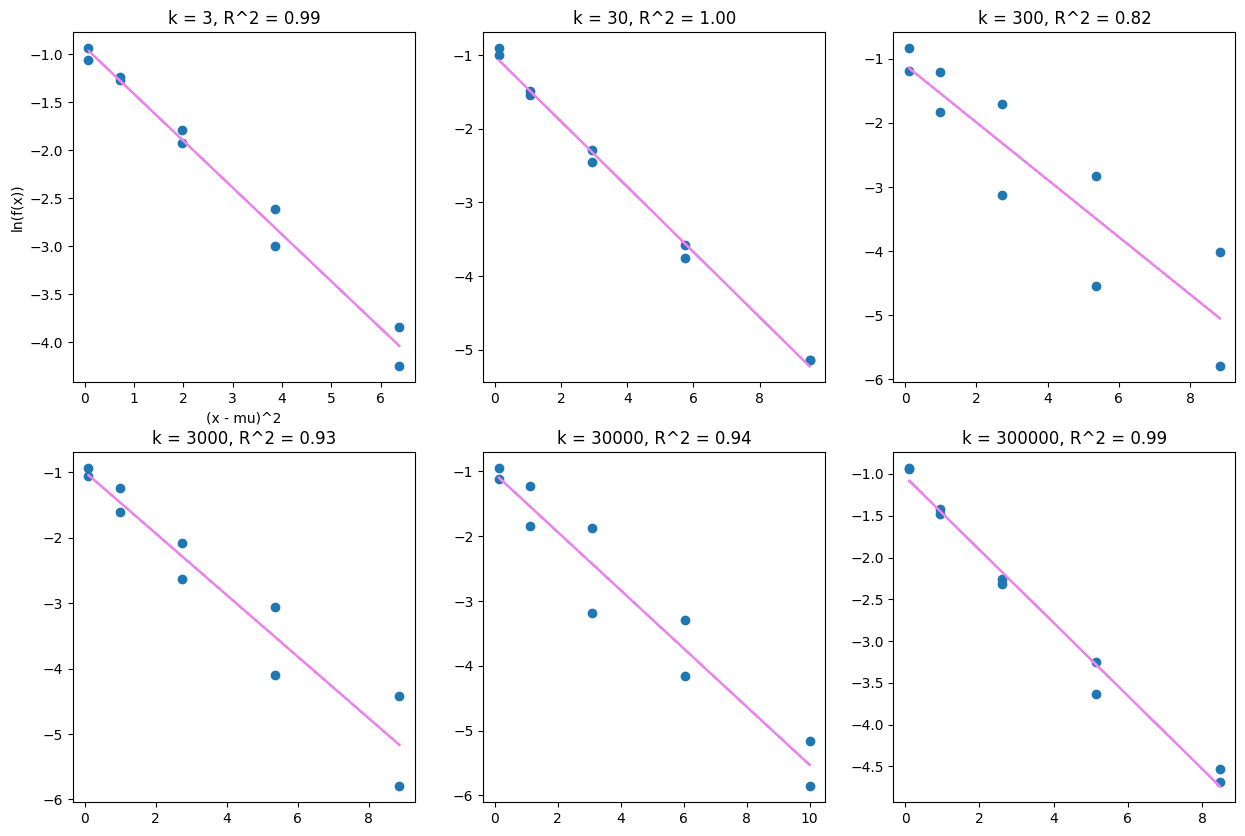

In [5]:
ks = [3, 30, 300, 3000, 30000, 300000]

fig, axs = plt.subplots(2, len(ks) // 2, figsize=(15, 10))

axs = axs.ravel()

for i, k in enumerate(ks):
    data = sample_normal(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    log_density = np.log(observed_freq)

    valid_idx = np.isfinite(log_density)
    x_valid = bin_centers[valid_idx]
    y_valid = log_density[valid_idx]

    x_mean = x_valid.mean()

    x_transformed = ((x_valid - x_mean) ** 2).reshape(-1, 1)
    lin_reg = LinearRegression().fit(x_transformed, y_valid)

    axs[i].scatter(x_transformed, y_valid)
    axs[i].plot(x_transformed, lin_reg.predict(x_transformed), color='violet')
    axs[i].set_title(f"k = {k}, R^2 = {lin_reg.score(x_transformed, y_valid):.2f}")
    if i == 0:
        axs[i].set_xlabel("(x - mu)^2")
        axs[i].set_ylabel("ln(f(x))")

# 2. Генерация распределения $\chi^2$

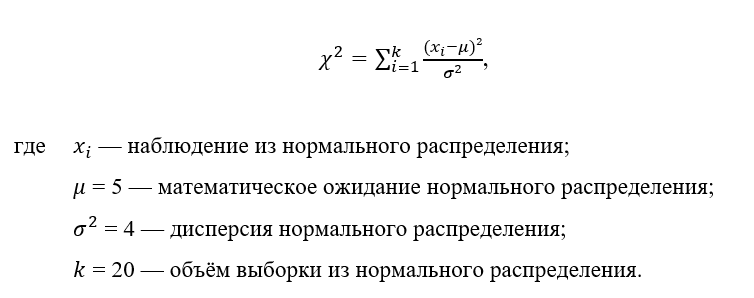

In [6]:
def sample_chi2(n=1, k=1):
    return np.array([(sample_normal(n=k) ** 2).sum() for _ in range(n)])

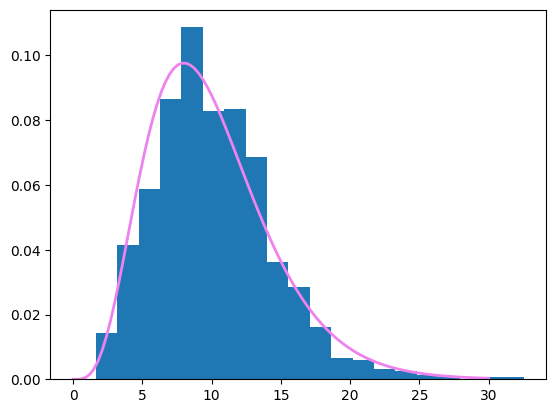

In [7]:
data = sample_chi2(n=1000, k=10)

x = np.linspace(0, 30, 100)
p = stats.chi2.pdf(x, 10)
plt.hist(data, density=True, bins=20)
plt.plot(x, p, c='violet', lw=2)

## 2.1 Тест на $\chi^2$ распределение с помощью критерия Пирсона

In [8]:
ks = [1, 3, 5, 10]

for k in ks:
    print(f'k = {k}')

    data = sample_chi2(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.chi2.cdf(bin_edges, df=k)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=1)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 1
Статистика χ²: 21.14032068823124
p-value: 0.006783874762796883

k = 3
Статистика χ²: 11.905139305141898
p-value: 0.15548678414165146

k = 5
Статистика χ²: 10.992251790492567
p-value: 0.2021386096396028

k = 10
Статистика χ²: 10.615894370979337
p-value: 0.2244269588621663



# 3. Генерация распределения Фишера

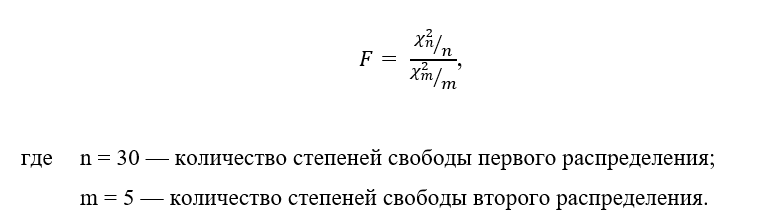

In [9]:
def sample_f(n=1, d1=1, d2=1):
    return np.array([(sample_chi2(k=d1) / d1) / (sample_chi2(k=d2) / d2) for _ in range(n)])

(-0.5, 10.0)

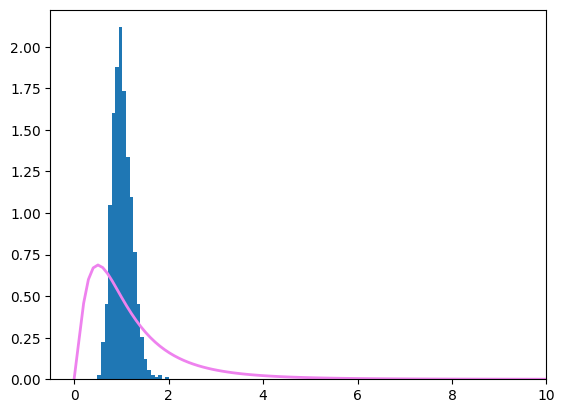

In [11]:
data = sample_f(n=1000, d1=100, d2=100)

x = np.linspace(0, 10, 100)
p = stats.f.pdf(x, 5, 10)
plt.hist(data, density=True, bins=20)
plt.plot(x, p, c='violet', lw=2)
plt.xlim((-0.5, 10))

## 3.1 Тест на распределение Фишера с помощью критерия Пирсона

In [12]:
ds = [(6, 60), (40, 20), (5, 5)]

for d1, d2 in ds:
    print(f'd1 = {d1}, d2 = {d2}')

    data = sample_f(1000, d1, d2)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.f.cdf(bin_edges, d1, d2)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=2)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

d1 = 6, d2 = 60
Статистика χ²: 6.267990990066302
p-value: 0.5088291592049585

d1 = 40, d2 = 20
Статистика χ²: 7.144499851130372
p-value: 0.4139913944137448

d1 = 5, d2 = 5
Статистика χ²: 15.253007533541284
p-value: 0.03288957069854907



# 4. Генерация t распределения

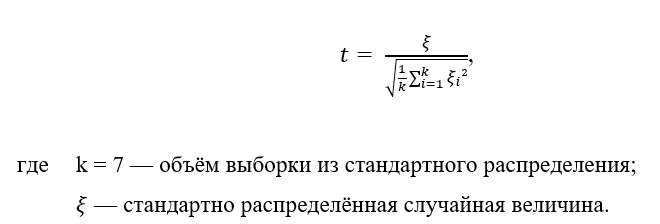

In [13]:
def sample_t(n=1, k=2):
    return np.array([sample_normal() / ((sample_normal(n=k) ** 2).mean() ** 0.5) for _ in range(n)])

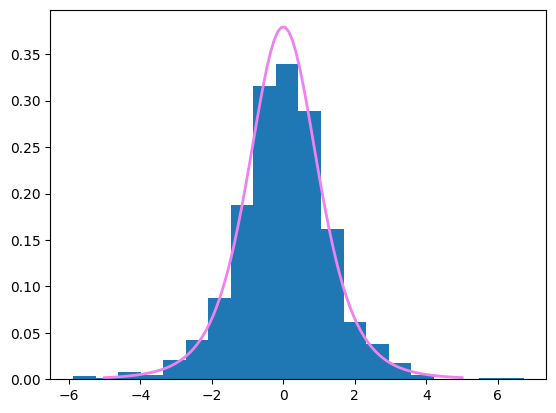

In [14]:
data = sample_t(n=1000, k=5)

x = np.linspace(-5, 5, 100)
p = stats.t.pdf(x, 5)
plt.hist(data, density=True, bins=20)
plt.plot(x, p, c='violet', lw=2)

# 4.1 Тест на t распределение с помощью критерия Пирсона

In [15]:
ks = [3, 5, 9]

for k in ks:
    print(f'k = {k}')

    data = sample_t(1000, k=k)

    observed_freq, bin_edges = np.histogram(data, bins=10)

    cdf = stats.t.cdf(bin_edges, df=k)
    expected_freq = len(data) * np.diff(cdf)

    expected_freq *= observed_freq.sum() / expected_freq.sum()

    chi2_stat, p_value = stats.chisquare(f_obs=observed_freq, f_exp=expected_freq, ddof=1)

    print(f"Статистика χ²: {chi2_stat}")
    print(f"p-value: {p_value}\n")

k = 3
Статистика χ²: 144.9469216787373
p-value: 2.2164583960153004e-27

k = 5
Статистика χ²: 19.49347873426276
p-value: 0.012432040818301206

k = 9
Статистика χ²: 14.951220208369936
p-value: 0.06010092125450467

